# Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.


**Описание тарифов**

* Тариф «Смарт»
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
* минута разговора: 3 рубля
* сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей

   
* Тариф «Ультра»
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
* минута разговора: 1 рубль
* сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей

Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.


**Описание данных**


**Таблица users** (информация о пользователях):


* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана


**Таблица calls** (информация о звонках):


* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок


**Таблица messages** (информация о сообщениях):


* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение


**Таблица internet** (информация об интернет-сессиях):


* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя


**Таблица tariffs** (информация о тарифах):


* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


Примечание. Если объединение таблиц методом merge приводит к ошибке dead kernell, примените метод join — это облегчит нагрузку на Jupyter Notebook.

### Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
import math
from scipy import stats as st
from IPython.display import display
import matplotlib.pyplot as plt
pd.options.display.max_columns = None

calls_data = pd.read_csv('/datasets/calls.csv')
users_data = pd.read_csv('/datasets/users.csv')
messages_data = pd.read_csv('/datasets/messages.csv')
internet_data = pd.read_csv('/datasets/internet.csv')
tariffs_data = pd.read_csv('/datasets/tariffs.csv')

display(
    calls_data.head(2), 
    users_data.head(2),
    messages_data.head(2),
    internet_data.head(2),
    tariffs_data
)
calls_data.info()
users_data.info()
messages_data.info()
internet_data.info()
tariffs_data.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory

### Вывод:

1. Все таблицы разного размера
2. Все таблицы объединяют столбцы `"user_id"` и `"tariff"`, `"tariff_name"`
3. Есть ненужный столбец `"Unnamed: 0`"
4. Столбец `"duration"` содержит значения `0.0`
5. Столбец `"churn_date"` содержит `462` пропуска
6. В столбцах с датами необходимо сменить тип данных
7. Столбцы `"duration"` и `"mb_used"` необходимо округлить

### Шаг 2. Подготовьте данные

* Приведите данные к нужным типам;
* Найдите и исправьте ошибки в данных.
* Поясните, какие ошибки вы нашли и как их исправили. Обратите внимание, что длительность многих звонков — 0.0 минут. Это могут быть пропущенные звонки. Обрабатывать ли эти нулевые значения, решать вам — оцените, как их отсутствие повлияет на результаты анализа.
* Посчитайте для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [2]:
display(internet_data.query('user_id == 1106'))

,Unnamed: 0,id,mb_used,session_date,user_id
30198,30198,1106_0,275.28,2018-07-27,1106
30199,30199,1106_1,0.00,2018-07-20,1106
30200,30200,1106_2,162.24,2018-05-19,1106
30201,30201,1106_3,424.60,2018-05-15,1106
30202,30202,1106_4,575.64,2018-08-05,1106
...,...,...,...,...,...
30512,30512,1106_314,445.65,2018-07-31,1106
30513,30513,1106_315,443.63,2018-08-28,1106
30514,30514,1106_316,401.66,2018-09-04,1106
30515,30515,1106_317,834.46,2018-08-06,1106


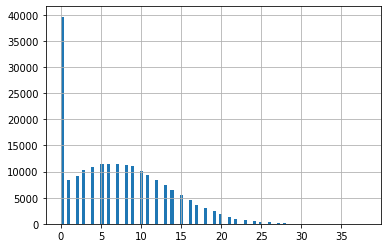

1377    336
1168    308
1453    295
1375    290
1196    262
1021    254
1363    244
1282    240
1057    216
1356    214
Name: user_id, dtype: int64

1377    1760
1168    1692
1375    1560
1453    1440
1196    1240
1021    1224
1363    1200
1282    1188
1458    1155
1381    1092
Name: user_id, dtype: int64

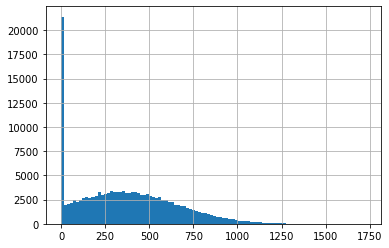

1204    144
1496    141
1429    125
1119    124
1227    121
1314    117
1219    115
1135    115
1045    113
1251    112
Name: user_id, dtype: int64

1496    834
1227    812
1204    789
1240    764
1251    759
1385    755
1072    745
1429    736
1373    711
1219    708
Name: user_id, dtype: int64

In [3]:
def rounded(duration_usedMb):
    """
    функция округляет значения столбца
    если дробная часть больше, чем .0, то округляет 
    целую часть в большую сторону
    """
    result = math.ceil(duration_usedMb)
    return result

calls_data['duration'] = calls_data.apply(lambda row: rounded(row['duration']), axis=1) # применяю функцию к столбцу 'duration'
internet_data['mb_used'] = internet_data.apply(lambda row: rounded(row['mb_used']), axis=1) # применяю функцию к столбцу 'mb_used'

def types(data, column, types):
    """
    функция для замены типов данных
    """
    data[column] = data[column].astype(types)

types(calls_data, 'call_date', 'datetime64[ns]')       # применяю функцию к столбцу 'call_date'
types(users_data, 'reg_date', 'datetime64[ns]')        # применяю функцию к столбцу 'reg_date'
types(messages_data, 'message_date', 'datetime64[ns]') # применяю функцию к столбцу 'message_date'
types(internet_data, 'session_date', 'datetime64[ns]') # применяю функцию к столбцу 'session_date'

internet_data.drop('Unnamed: 0', axis='columns') # удаляю ненужный столбец

# проверяю данные на наличие выбросов для столбцов calls_data['duration'] и internet_data['mb_used']
calls_data['duration'].hist(bins=100)
plt.show()

display(calls_data
        .query('duration == 0')['user_id']
        .value_counts()
        .head(10))
display(calls_data['user_id'].value_counts().head(10))

internet_data['mb_used'].hist(bins=100)
plt.show()

display(internet_data
        .query('mb_used == 0')['user_id']
        .value_counts()
        .head(10))
display(internet_data['user_id'].value_counts().head(10))

# calls_data = calls_data.query('duration != 0')
internet_data = internet_data.query('mb_used != 0') # удалил нулевые значения из internet_data['mb_used']


In [4]:
calls_data['month'] = calls_data['call_date'].dt.month          # добавляю столбец с номером месяца в таблицу calls_data
calls_data['sum_calls'] = 1                                     # создаю столбец 'sum_calls' в таблице calls_data для подсчета кол-ва звонков в месяц для каждого абонента
messages_data['month'] = messages_data['message_date'].dt.month # добавляю столбец с номером месяца в таблицу messages_data
messages_data['sum_messages'] = 1                               # создаю столбец 'sum_messages' в таблице messages_data для подсчета кол-ва сообщений в месяц для каждого абонента
internet_data['month'] = internet_data['session_date'].dt.month # добавляю столбец с номером месяца в таблицу internet_data

data = (
    calls_data
    .groupby(['user_id', 'month'])['duration', 'sum_calls']
    .sum()
    .reset_index()
) # группирую calls_data по столбцам 'user_id', 'month' с суммированием 'duration', 'sum_calls'
data_1 = (
    messages_data
    .groupby(['user_id', 'month'])['sum_messages']
    .sum()
    .reset_index()
) # группирую messages_data по столбцам 'user_id', 'month' с суммированием 'sum_messages'
data_2 = (
    internet_data
    .groupby(['user_id', 'month'])['mb_used']
    .sum()
    .reset_index()
) # группирую internet_data по столбцам 'user_id', 'month' с суммированием 'mb_used'

data_merge = users_data.merge(data_2, on='user_id', how='outer')                      # объединение таблиц users_data и data по столбцу 'user_id'
data_merge = data_merge.merge(data, on=['user_id', 'month'], how='outer')             # объединение таблиц data_merge и data_1 по столбцам 'user_id', 'month'
data_merge = data_merge.merge(data_1, on=['user_id', 'month'], how='outer')           # объединение таблиц data_merge и data_2 по столбцам 'user_id', 'month'
data_merge = data_merge.merge(tariffs_data, left_on='tariff', right_on='tariff_name') # объединение таблиц data_merge и tariffs_data по столбцам 'tariff', 'tariff_name'

data_merge[['duration', 'sum_calls', 'sum_messages', 'mb_used']] = data_merge[['duration', 'sum_calls', 'sum_messages', 'mb_used']].fillna(0)
# заменил NaN на 0 в определённых столбцах
data_merge = data_merge[data_merge['month'].notna()] # удалил NaN из month
data_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3201 entries, 0 to 3203
Data columns (total 21 columns):
user_id                  3201 non-null int64
age                      3201 non-null float64
churn_date               186 non-null object
city                     3201 non-null object
first_name               3201 non-null object
last_name                3201 non-null object
reg_date                 3201 non-null datetime64[ns]
tariff                   3201 non-null object
month                    3201 non-null float64
mb_used                  3201 non-null float64
duration                 3201 non-null float64
sum_calls                3201 non-null float64
sum_messages             3201 non-null float64
messages_included        3201 non-null int64
mb_per_month_included    3201 non-null int64
minutes_included         3201 non-null int64
rub_monthly_fee          3201 non-null int64
rub_per_gb               3201 non-null int64
rub_per_message          3201 non-null int64
rub_per_minut

In [10]:


def func(rub_monthly_fee, 
         duration, 
         minutes_included, 
         rub_per_minute,
         sum_messages,
         messages_included,
         rub_per_message,
         mb_used,
         mb_per_month_included,
         rub_per_gb):
    
    """
    функция для подсчета суммы, 
    потраченной каждым абонентом 
    за каждый месяц пользования услугами компании
    """
    
    summ = 0
    summ += rub_monthly_fee
    if duration > minutes_included:
        summ += (duration - minutes_included) * rub_per_minute
    else:
        summ += 0
    if sum_messages > messages_included:
        summ += (sum_messages - messages_included) * rub_per_message
    else:
        summ += 0
    if mb_used > mb_per_month_included:
        summ += math.ceil((mb_used - mb_per_month_included) / 1024) * rub_per_gb
    else:
        summ += 0    
    return summ

data_merge['monthly_profit_per_user'] = (
    data_merge
    .apply(lambda row: func(
        row['rub_monthly_fee'], 
        row['duration'], 
        row['minutes_included'], 
        row['rub_per_minute'],
        row['sum_messages'],
        row['messages_included'],
        row['rub_per_message'],
        row['mb_used'],
        row['mb_per_month_included'],
        row['rub_per_gb']), axis=1))

In [6]:
print(f'Количество клиентов: {data_merge.user_id.nunique()}')

Количество клиентов: 497


<div class="alert alert-success">
<b>Комментарий ревьюера:</b>

Выручка посчитана верно.
</div>

In [7]:
data_merge['monthly_profit_per_user'].describe()

count    3201.000000
mean     1531.771634
std       800.523058
min       550.000000
25%       750.000000
50%      1655.000000
75%      1950.000000
max      6770.000000
Name: monthly_profit_per_user, dtype: float64

### Вывод:

1. Округлил значения столбцов `"duration"` и `"mb_used"`.
2. Заменил типы данных для столбцов `'call_date', 'reg_date', 'message_date', 'session_date'`
3. Удалил столбец `'Unnamed: 0'`.
4. Решил проверить столбцы `calls_data['duration']` и `internet_data['mb_used']` на выбросы.
По гистограммам видно, что распределение данных в обоих случаях стремится к нормальному, но есть большие выбросы на `0` - около `40 тыс` для звонков и более `20 тыс` для интернет трафика.
Стал исследовать все `'user_id'`, где значения равны `0` и обнаружил, что пользователи, которые чаще всего звонят или выходят в интернет и имеют больше всего `0`.
В итоге принял решение, что из `internet_data` можно удалить все 0 значения, так как пользователи выходят в интернет не раз и не два за день и даже если группировать по дням, то в итоге нулевых значений почти не останется, а по месяцам и тем более.
Из `calls_data` не стал удалять 0 по причине наличия столбца `sum_calls`. Вцелом удаление не повлияет на помесячную выручку с пользователей, но столбец `sum_calls` сильно изменится, так как удалится пятая часть данных.

5. Добавил `calls_data['month']`, `messages_data['month']`, `internet_data['month']` - столбцы с номерами месяцев.
6. Добавил `calls_data['sum_calls']`, `messages_data['sum_messages']` - столбцы, по которым можно посчитать количество сообщений и звонков для каждого пользователя за месяц.
7. Сгруппировал `calls_data, messages_data, internet_data`.
8. Объединил все таблицы в одну `data_merge`.
9. Посчитал с помощью функции `помесячную выручку с каждого пользователя`.


### Шаг 3. Проанализируйте данные

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

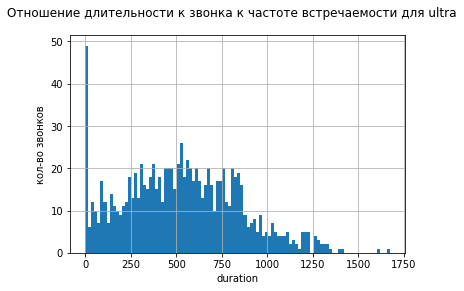

Для звонков тарифа ultra: среднее: 530.1837782340863, дисперсия: 100803.63628334647, стандартное отклонение: 317.49588388410086, правило трёх сигм: 1482.671429886389


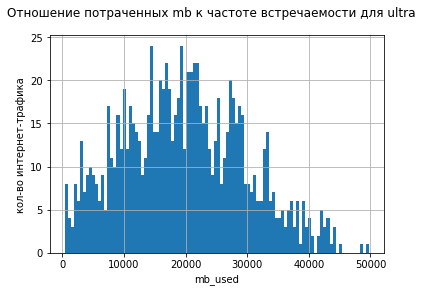

Для интернет-трафика тарифа ultra: среднее: 19706.979466119097, дисперсия: 98746498.93277423, стандартное отклонение: 9937.127297804644, правило трёх сигм: 49518.361359533024


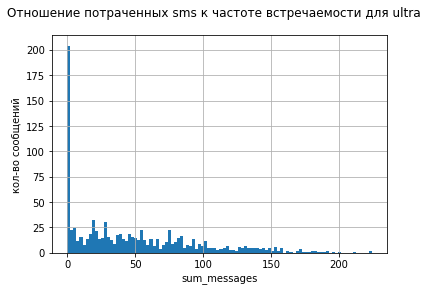

Для сообщений тарифа ultra: среднее: 49.63347022587269, дисперсия: 2302.0577069585165, стандартное отклонение: 47.979763515033255, правило трёх сигм: 193.57276077097245


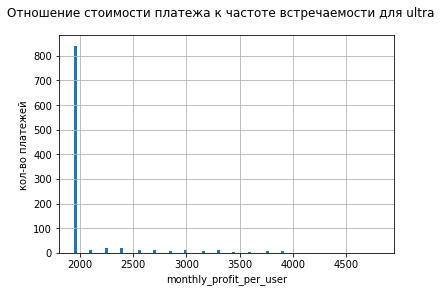

count     974.000000
mean     2072.433265
std       380.717575
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: monthly_profit_per_user, dtype: float64

Дисперсия равна: 144945.87169806537


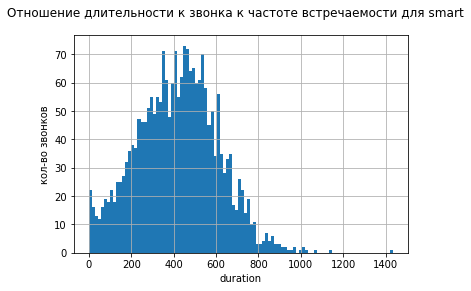

Для звонков тарифа smart: среднее: 418.26852267624605, дисперсия: 36127.77871672938, стандартное отклонение: 190.07308782868074, правило трёх сигм: 988.4877861622883


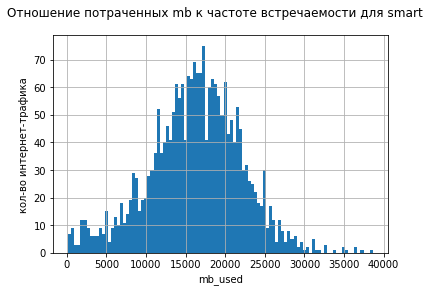

Для интернет-трафика тарифа smart: среднее: 16243.763358778626, дисперсия: 34340091.55358943, стандартное отклонение: 5860.041941282454, правило трёх сигм: 33823.889182625986


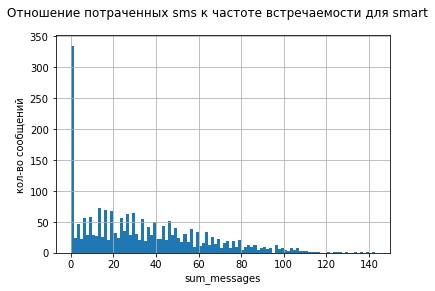

Для сообщений тарифа smart: среднее: 33.41311180960934, дисперсия: 796.5857758918057, стандартное отклонение: 28.223851188167178, правило трёх сигм: 118.08466537411087


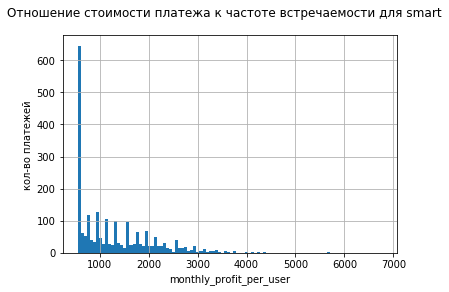

count    2227.000000
mean     1295.308038
std       820.998289
min       550.000000
25%       550.000000
50%      1039.000000
75%      1750.000000
max      6770.000000
Name: monthly_profit_per_user, dtype: float64

Дисперсия равна: 674038.1907844227


In [20]:
data_filt_ultra = data_merge.query('tariff == "ultra"') # фильтрую data_merge по значениям "ultra"

data_filt_ultra['duration'].hist(bins=100) # гистограмма для звонков
plt.xlabel('duration')
plt.ylabel("кол-во звонков")
plt.suptitle("Отношение длительности к звонка к частоте встречаемости для ultra")
plt.show()
print('Для звонков тарифа ultra: среднее: {0}, дисперсия: {1}, стандартное отклонение: {2}, правило трёх сигм: {3}'.format(data_filt_ultra['duration'].mean(), data_filt_ultra['duration'].var(ddof=1), data_filt_ultra['duration'].std(ddof=1), data_filt_ultra['duration'].mean()+3*data_filt_ultra['duration'].std(ddof=1)))

data_filt_ultra['mb_used'].hist(bins=100) # гистограмма для потраченных мегабайт
plt.xlabel('mb_used')
plt.ylabel("кол-во интернет-трафика")
plt.suptitle("Отношение потраченных mb к частоте встречаемости для ultra")
plt.show()
print('Для интернет-трафика тарифа ultra: среднее: {0}, дисперсия: {1}, стандартное отклонение: {2}, правило трёх сигм: {3}'.format(data_filt_ultra['mb_used'].mean(), data_filt_ultra['mb_used'].var(ddof=1), data_filt_ultra['mb_used'].std(ddof=1), data_filt_ultra['mb_used'].mean()+3*data_filt_ultra['mb_used'].std(ddof=1)))

data_filt_ultra['sum_messages'].hist(bins=100) # гистограмма для сообщений
plt.xlabel('sum_messages')
plt.ylabel("кол-во сообщений")
plt.suptitle("Отношение потраченных sms к частоте встречаемости для ultra")
plt.show()
print('Для сообщений тарифа ultra: среднее: {0}, дисперсия: {1}, стандартное отклонение: {2}, правило трёх сигм: {3}'.format(data_filt_ultra['sum_messages'].mean(), data_filt_ultra['sum_messages'].var(ddof=1), data_filt_ultra['sum_messages'].std(ddof=1), data_filt_ultra['sum_messages'].mean()+3*data_filt_ultra['sum_messages'].std(ddof=1)))

data_filt_ultra['monthly_profit_per_user'].hist(bins=100)                         # строю гистограмму
plt.xlabel('monthly_profit_per_user')
plt.ylabel("кол-во платежей")
plt.suptitle("Отношение стоимости платежа к частоте встречаемости для ultra")
plt.show()
display(data_filt_ultra['monthly_profit_per_user'].describe())                    # вывод общей информации о таблице
print('Дисперсия равна:', data_filt_ultra['monthly_profit_per_user'].var(ddof=1)) # расчет дисперсии


data_filt_smart = data_merge.query('tariff == "smart"') # фильтрую data_merge по значениям "smart"

data_filt_smart['duration'].hist(bins=100) # гистограмма для звонков
plt.xlabel('duration')
plt.ylabel("кол-во звонков")
plt.suptitle("Отношение длительности к звонка к частоте встречаемости для smart")
plt.show()
print('Для звонков тарифа smart: среднее: {0}, дисперсия: {1}, стандартное отклонение: {2}, правило трёх сигм: {3}'.format(data_filt_smart['duration'].mean(), data_filt_smart['duration'].var(ddof=1), data_filt_smart['duration'].std(ddof=1), data_filt_smart['duration'].mean()+3*data_filt_smart['duration'].std(ddof=1)))

data_filt_smart['mb_used'].hist(bins=100) # гистограмма для потраченных мегабайт
plt.xlabel('mb_used')
plt.ylabel("кол-во интернет-трафика")
plt.suptitle("Отношение потраченных mb к частоте встречаемости для smart")
plt.show()
print('Для интернет-трафика тарифа smart: среднее: {0}, дисперсия: {1}, стандартное отклонение: {2}, правило трёх сигм: {3}'.format(data_filt_smart['mb_used'].mean(), data_filt_smart['mb_used'].var(ddof=1), data_filt_smart['mb_used'].std(ddof=1), data_filt_smart['mb_used'].mean()+3*data_filt_smart['mb_used'].std(ddof=1)))

data_filt_smart['sum_messages'].hist(bins=100) # гистограмма для сообщений
plt.xlabel('sum_messages')
plt.ylabel("кол-во сообщений")
plt.suptitle("Отношение потраченных sms к частоте встречаемости для smart")
plt.show()
print('Для сообщений тарифа smart: среднее: {0}, дисперсия: {1}, стандартное отклонение: {2}, правило трёх сигм: {3}'.format(data_filt_smart['sum_messages'].mean(), data_filt_smart['sum_messages'].var(ddof=1), data_filt_smart['sum_messages'].std(ddof=1), data_filt_smart['sum_messages'].mean()+3*data_filt_smart['sum_messages'].std(ddof=1)))

data_filt_smart['monthly_profit_per_user'].hist(bins=100)                         # строю гистограмму
plt.xlabel('monthly_profit_per_user')
plt.ylabel("кол-во платежей")
plt.suptitle("Отношение стоимости платежа к частоте встречаемости для smart")
plt.show()
display(data_filt_smart['monthly_profit_per_user'].describe())                    # вывод общей информации о таблице
print('Дисперсия равна:', data_filt_smart['monthly_profit_per_user'].var(ddof=1)) # расчет дисперсии

### Вывод:

* Для тарифа ultra:
    * Гистограмма звонков стремится к нормальному распределению, имеет положительную скошенность.
    * среднее - 530 минут разговора, стандартное отклонение - 317, по правилу трёх сигм получаем, что 99% пользователей достаточно 1482 минуты на звонки в месяц.
    * Гистограмма использованных мегабайт имеет нормальное распределение значений.
    * Среднее - 19706 мб, стандартное отклонение - 9937, по правилу трёх сигм получаем, что 99% пользователей достаточно 49518 мб интернет-трафика в месяц.
    * Гистограмма сообщений имеет распределение Пуассона.
    * Среднее - 49, стандартное отклонение - 47, по правилу трёх сигм получаем, что 99% пользователей достаточно 193 сообщения в месяц.
    * На последней гистограмме видно, что более 800 ежемесячных платежей из 974 равны платежу по тарифу и не больше, но есть и люди, которым не хватает минут, мегабайт или сообщений и такие люди раскошеливаются вплоть до 4800р за месяц, но их очень мало.
    
* Для тарифа smart:
    * Гистограмма звонков стремится к нормальному распределению.
    * среднее - 418 минут разговора, стандартное отклонение - 190, по правилу трёх сигм получаем, что 99% пользователей достаточно 988 минут на звонки в месяц.
    * Гистограмма использованных мегабайт имеет нормальное распределение значений.
    * Среднее - 16243 мб, стандартное отклонение - 5860, по правилу трёх сигм получаем, что 99% пользователей достаточно 33823 мб интернет-трафика в месяц.
    * Гистограмма сообщений имеет распределение Пуассона.
    * Среднее - 33, стандартное отклонение - 28, по правилу трёх сигм получаем, что 99% пользователей достаточно 118 сообщений в месяц.
    * На последней гистограмме видно, что около 650 ежемесячных платежей из 2227 равны платежу по тарифу и не больше, но есть и люди, которым не хватает минут, мегабайт или сообщений и такие люди раскошеливаются вплоть до 6770р за месяц, но их очень мало.

    
Подводя итоги по двум выборкам видно, что пользователи тарифа ultra наиболее верно выбрали для себя тариф и благодаря этому не переплачивают.
    
А вот пользователям тарифа smart всё время либо нужно идти на компромисс, либо раскошеливаться, т.к. среднее по интернету уже не укладывается в рамки тарифа (15360 мб), тоесть всем пользователям, чьи месячные платежи на графике находятся в интервале от 1950р до 6770р однозначно стоит задуматься о смене тарифа, а таких платежей приблизительно 1/4 часть.

### Шаг 4. Проверьте гипотезы
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;
* Пороговое значение alpha задайте самостоятельно.


* Поясните:
  1. как вы формулировали нулевую и альтернативную гипотезы;
  2. какой критерий использовали для проверки гипотез и почему.

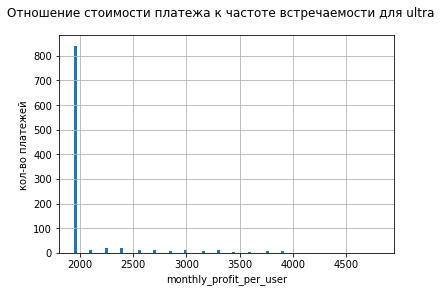

count     974.000000
mean     2072.433265
std       380.717575
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: monthly_profit_per_user, dtype: float64

Дисперсия равна: 144945.87169806537


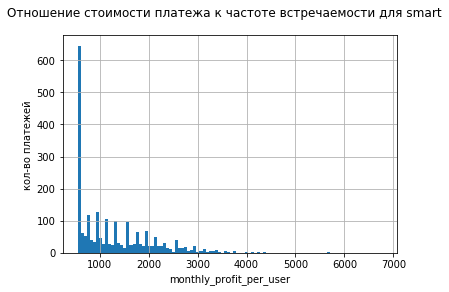

count    2227.000000
mean     1295.308038
std       820.998289
min       550.000000
25%       550.000000
50%      1039.000000
75%      1750.000000
max      6770.000000
Name: monthly_profit_per_user, dtype: float64

Дисперсия равна: 674038.1907844227
р-значение: 7.438270645731764e-157
Отвергаем нулевую гипотезу


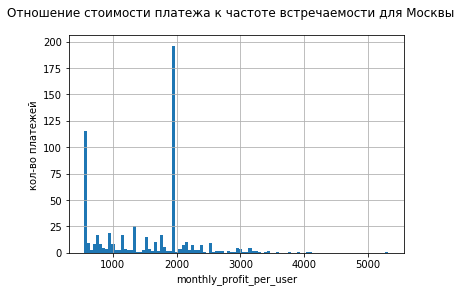

count     611.000000
mean     1550.805237
std       752.451347
min       550.000000
25%       798.000000
50%      1750.000000
75%      1950.000000
max      5321.000000
Name: monthly_profit_per_user, dtype: float64

Дисперсия равна: 566183.0292184273


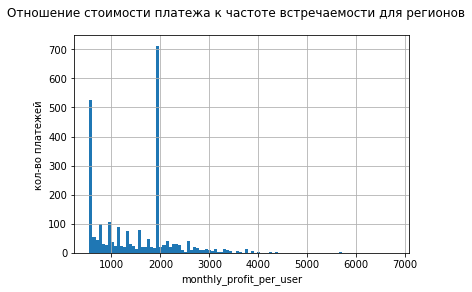

count    2590.000000
mean     1527.281467
std       811.522303
min       550.000000
25%       750.000000
50%      1576.500000
75%      1950.000000
max      6770.000000
Name: monthly_profit_per_user, dtype: float64

Дисперсия равна: 658568.4487487157
р-значение: 0.5136009483199212
Не получилось отвергнуть нулевую гипотезу


In [19]:
data_filt_ultra['monthly_profit_per_user'].hist(bins=100)                         # строю гистограмму
plt.xlabel('monthly_profit_per_user')
plt.ylabel("кол-во платежей")
plt.suptitle("Отношение стоимости платежа к частоте встречаемости для ultra")
plt.show()
display(data_filt_ultra['monthly_profit_per_user'].describe())                    # вывод общей информации о таблице
print('Дисперсия равна:', data_filt_ultra['monthly_profit_per_user'].var(ddof=1)) # расчет дисперсии
data_filt_smart['monthly_profit_per_user'].hist(bins=100)                         # строю гистограмму
plt.xlabel('monthly_profit_per_user')
plt.ylabel("кол-во платежей")
plt.suptitle("Отношение стоимости платежа к частоте встречаемости для smart")
plt.show()
display(data_filt_smart['monthly_profit_per_user'].describe())                    # вывод общей информации о таблице
print('Дисперсия равна:', data_filt_smart['monthly_profit_per_user'].var(ddof=1)) # расчет дисперсии


alpha = .01
results = st.ttest_ind(
    data_filt_ultra['monthly_profit_per_user'],
    data_filt_smart['monthly_profit_per_user']
)

print('р-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    
data_filt_moscow = data_merge.query('city == "Москва"')
data_filt_noMoscow = data_merge.query('city != "Москва"')

data_filt_moscow['monthly_profit_per_user'].hist(bins=100)                         # строю гистограмму
plt.xlabel('monthly_profit_per_user')
plt.ylabel("кол-во платежей")
plt.suptitle("Отношение стоимости платежа к частоте встречаемости для Москвы")
plt.show()
display(data_filt_moscow['monthly_profit_per_user'].describe())                    # вывод общей информации о таблице
print('Дисперсия равна:', data_filt_moscow['monthly_profit_per_user'].var(ddof=1)) # расчет дисперсии
data_filt_noMoscow['monthly_profit_per_user'].hist(bins=100)                         # строю гистограмму
plt.xlabel('monthly_profit_per_user')
plt.ylabel("кол-во платежей")
plt.suptitle("Отношение стоимости платежа к частоте встречаемости для регионов")
plt.show()
display(data_filt_noMoscow['monthly_profit_per_user'].describe())                    # вывод общей информации о таблице
print('Дисперсия равна:', data_filt_noMoscow['monthly_profit_per_user'].var(ddof=1)) # расчет дисперсии    
    
alpha = .05
results = st.ttest_ind(
    data_merge.query('city == "Москва"')['monthly_profit_per_user'],
    data_merge.query('city != "Москва"')['monthly_profit_per_user']
)

print('р-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")
    

### Вывод:

* H0 в 1 случае означает, что средняя выручка пользователей тарифов «Ультра» и «Смарт» НЕ различается
* Н1 в 1 случае означает, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
    
    
* H0 во 2 случае означает, что средняя выручка пользователей из Москвы НЕ отличается от выручки пользователей из других регионов
* Н1 во 2 случае означает, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
    
    
* В обеих гипотезах я задал `alpha` отталкиваясь от значения `p-value` и исходя из общепринятых значений в `1% и 5%`, и первый раз получил отклонение нулевой гипотезы, а во второй раз не получилось отклонить нулевую гипотезу, т.к. `p-value=5,1%`, что абсолютно верно, т.к. среднее для `smart - 1295`, для `ultra - 2072`, с городами разница не существенна, но всёже отличие есть и составляет `61 рубль` в большую сторону для Москвы.
    
    
* Я использовал t-критерий Стьюдента для независимых выборок, потому как я сравнивал оба раза средние из выборок, различающихся по параметрам: в первом случае по тарифу, во втором по городу. Если бы я использовал одну выборку и сравнение проводил бы с ней же, но поменяв в ней значения одного из столбцов, то в этом случае использовал бы  t-критерий Стьюдента для связанных выборок.

<div class="alert alert-info">

Распределение Пуассона, а оно стремится к нормальному.

</div>

### Шаг 5. Напишите общий вывод

Задание было - определить, какой из тарифов приносит больше денег.
    
* Мной было установлено, что выгоднее рекламировать тариф smart т.к.:
    * в нём уже больше месячных платежей, что говорит о расположенности людей к более бюджетному тарифу.
    * порядка 1400 платежей больше стоимости тарифа и около 500 из них больше, чем стоит тариф ultra.
    * максимальная плата больше на 2000р, чем в тарифе ultra.

Проще говоря, люди хотят сэкономить, и 3/4 платежей действительно меньше стоимости ultra, но всёравно есть 1/4 платежей, которая больше стоимости ultra. И по количеству платежей эта самая 1/4 совсем немногим меньше всего количества платежей тарифа ultra.